In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.csgraph import connected_components
from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm


plt.rcParams.update({
    "text.usetex": True,
})

In [2]:
A = np.zeros((6, 6))
A[0, 1] = 1.0
A[0, 2] = 1.0
A[1, 2] = 1.0

A[3, 4] = 1.0
A[3, 5] = 1.0
A[4, 5] = 1.0

A += A.T

connected_components(A)

(2, array([0, 0, 0, 1, 1, 1], dtype=int32))

In [3]:
A

array([[0., 1., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 1., 0.]])

In [4]:
def alr(theta):
    return np.log(theta[:-1] / theta[-1])


def inv_alr(x):
    theta = np.concatenate([np.exp(x), np.array([1.0])])
    return theta / np.sum(theta)


def random_logisticMCAR(graph, Sigma, simulate_mtilde=True, eta=1.0, rho=0.9):
    n_comps, idxs = connected_components(graph)
    nloc = graph.shape[0]
    dim = Sigma.shape[0]
    mtildevec = np.zeros(nloc * dim)
    if simulate_mtilde is True:
        mtildes = np.random.normal(size=(n_comps, dim), scale=eta)
        for i in range(nloc):
            mtildevec[i * dim : (i+1) * dim] = mtildes[idxs[i]]
    
    F = np.diag(rho * np.sum(graph, axis=1) + (1-rho))
    cov = np.linalg.inv(np.kron(F - rho * graph, np.linalg.inv(Sigma)))
    trans_weights = mvn.rvs(mean=mtildevec, cov=cov).reshape((nloc, dim))
    return np.apply_along_axis(inv_alr, 1, trans_weights)


def random_CKCAR(ncomp, graph, a, b, tau=0.5, rho=0.9):
    nloc = graph.shape[0]
    F = np.diag(rho * np.sum(graph, axis=1) + (1-rho))
    Lambda = np.linalg.inv(F - rho * graph)
    h = np.arange(1, ncomp+1)
    mh = np.log(1.0 - 1.0 / (1 + np.exp(b - h * a)))
    out = np.zeros((nloc, ncomp))
    for i in range(ncomp):
        uh = mvn.rvs(mean=np.ones(nloc) * mh[i], cov=tau*Lambda)
        out[:, i] = np.exp(uh)
    out /= np.sum(out, axis=1).reshape(-1, 1)
    return out

def eval_mixture_dens(grid, weights, means, stddevs):
    out = []
    ngroups = weights.shape[0]
    eval_normals = np.vstack(
        [norm.pdf(grid, loc=m, scale=s) for m, s in zip(means, stddevs)])
    for i in range(ngroups):
        dens = np.multiply(eval_normals, weights[i, :].reshape(-1, 1)) 
        out.append(np.sum(dens, axis=0))
    return np.vstack(out)

In [5]:
b = 1.5
a = 0.5
h = np.arange(1, 40)
np.log(1.0 - 1.0 / (1 + np.exp(b - h * a)))

array([ -0.31326169,  -0.47407698,  -0.69314718,  -0.97407698,
        -1.31326169,  -1.70141328,  -2.12692801,  -2.57888973,
        -3.04858735,  -3.52975042,  -4.01814993,  -4.51104774,
        -5.00671535,  -5.50407844,  -6.00247569,  -6.50150231,
        -7.00091147,  -7.50055293,  -8.00033541,  -8.50020345,
        -9.0001234 ,  -9.50007485, -10.0000454 , -10.50002754,
       -11.0000167 , -11.50001013, -12.00000614, -12.50000373,
       -13.00000226, -13.50000137, -14.00000083, -14.5000005 ,
       -15.00000031, -15.50000019, -16.00000011, -16.50000007,
       -17.00000004, -17.50000002, -18.00000002])

In [6]:
ncomp = 6
sigma = np.eye(ncomp - 1)
means = np.linspace(-5, 5, ncomp)
stddevs = np.ones(11) * 0.25

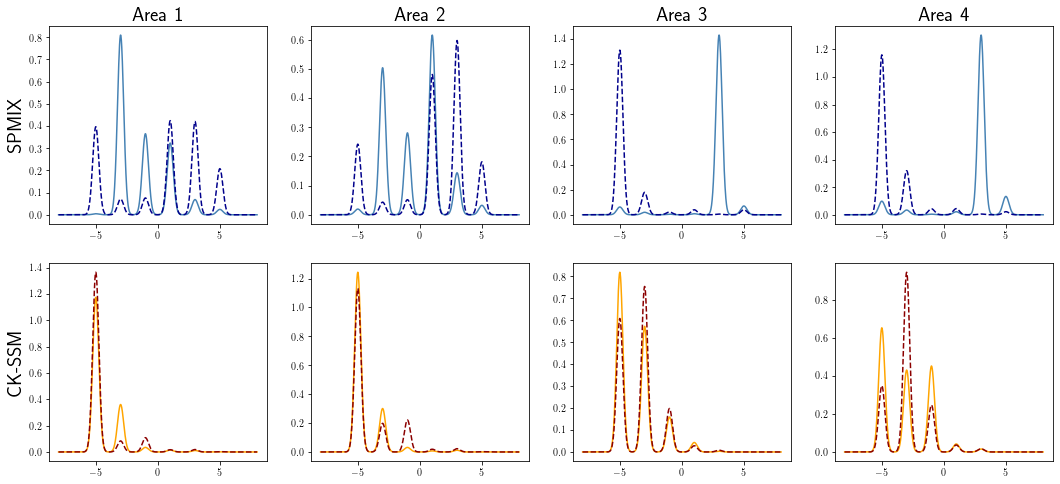

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))

grid = np.linspace(-8, 8, 1000)
toshow = [0, 1, 3, 4]

lty = ["-", "--"]
spmixcolors = ["steelblue", "darkblue"]
jocolors = ["orange", "darkred"]


for j in range(2):
    spmix_weights = random_logisticMCAR(A, sigma, eta=0.5)
    spmix_dens = eval_mixture_dens(grid, spmix_weights, means, stddevs)
    jo_weights = random_CKCAR(ncomp, A, tau=0.25, a=1.5, b=0.5, rho=0.9)
    jo_dens = eval_mixture_dens(grid, jo_weights, means, stddevs)
    
    for axind, i in enumerate(toshow):
        axes[0][axind].plot(grid, spmix_dens[i], lty[j], color=spmixcolors[j], lw=1.5)
        axes[1][axind].plot(grid, jo_dens[i], lty[j], color=jocolors[j], lw=1.5) 
        
for i in range(4):
    axes[0][i].set_title("Area {0}".format(i+1), fontsize=20)
    
axes[0][0].set_ylabel("SPMIX", fontsize=20)
axes[1][0].set_ylabel("CK-SSM", fontsize=20) 

plt.savefig("spmix_vs_jo_dens.pdf", bbox_inches="tight")  
plt.show()

# Compute Pairwise Distances

In [9]:
ncomp = 30
sigma = np.eye(ncomp - 1) * 0.5

etas = np.linspace(0, 5, 6)

dist_conn = {}
dist_ind = {}

for eta in etas:
    w = np.stack([random_logisticMCAR(A, sigma, eta=eta, rho=0.9) for i in range(100)])
    dist_conn[eta] = np.sum(np.abs(w[:, 0, :] - w[:, 1, :]), axis=-1) * 0.5
    dist_ind[eta] = np.sum(np.abs(w[:, 0, :] - w[:, -1, :]), axis=-1) * 0.5

In [10]:
avals = np.linspace(0.1, 1.0, 5)

dist_conn_jo = {}
dist_ind_jo = {}

for a in avals:
    w = np.stack([random_CKCAR(ncomp, A, tau=0.5, a=a, b=0.5, rho=0.9) for i in range(1000)])
    dist_conn_jo[a] = np.sum(np.abs(w[:, 0, :] - w[:, 1, :]), axis=-1) * 0.5
    dist_ind_jo[a] = np.sum(np.abs(w[:, 0, :] - w[:, -1, :]), axis=-1) * 0.5

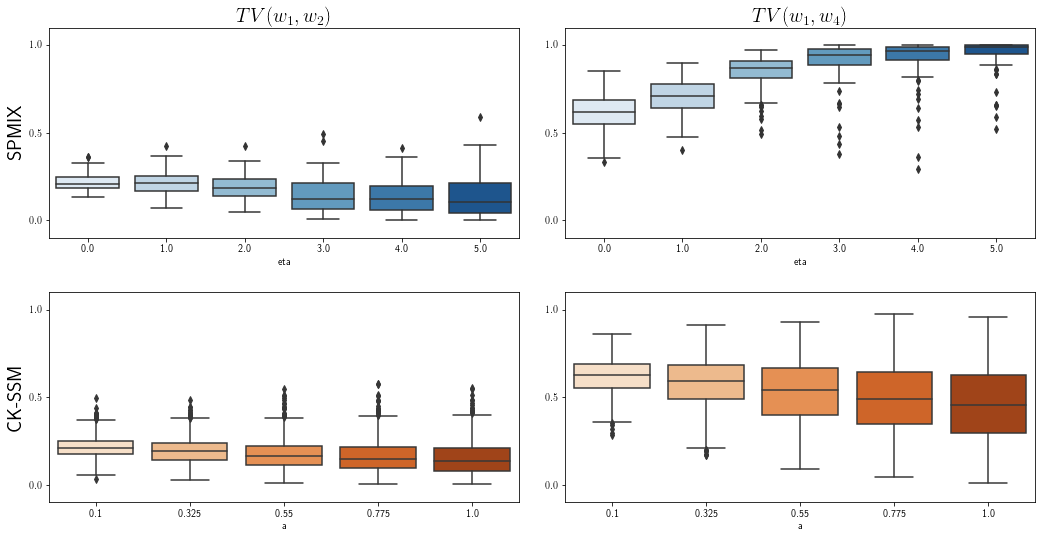

In [11]:
import seaborn as sns
import pandas as pd


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

sns.set(font_scale = 2)
sns.set_style("white")

df_conn = pd.DataFrame(dist_conn).melt()
df_conn.columns = ["eta", "dist"]
df_ind = pd.DataFrame(dist_ind).melt()
df_ind.columns = ["eta", "dist"]

sns.boxplot(x="eta", y="dist", data=df_conn, ax=axes[0][0], palette="Blues")
sns.boxplot(x="eta", y="dist", data=df_ind, ax=axes[0][1], palette="Blues")


df_conn = pd.DataFrame(dist_conn_jo).melt()
df_conn.columns = ["a", "dist"]
df_ind = pd.DataFrame(dist_ind_jo).melt()
df_ind.columns = ["a", "dist"]

sns.boxplot(x="a", y="dist", data=df_conn, ax=axes[1][0], palette="Oranges")
sns.boxplot(x="a", y="dist", data=df_ind, ax=axes[1][1], palette="Oranges")


for i in range(2):
    for j in range(2):
        axes[i][j].set_ylim(-0.1, 1.1)
        
axes[0][1].set_ylabel("")
axes[1][1].set_ylabel("")

axes[0][0].set_title(r"$TV(w_1, w_2)$", fontsize=20)
axes[0][1].set_title(r"$TV(w_1, w_4)$", fontsize=20)
axes[0][0].set_ylabel("SPMIX", fontsize=20)
axes[1][0].set_ylabel("CK-SSM", fontsize=20)

        
plt.tight_layout()
plt.savefig("distances_prior.pdf")
plt.show()